In [1]:
import numpy as np
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
from scipy import signal
from scipy import interpolate
from tqdm import tqdm
import json
from pandas import json_normalize
from pywt import wavedec
from math import log10
from pathlib import Path

# Получение и обработка данных (выполнение вейвлет-преобразования)

In [2]:
# начальные параметры
class Initial_params:
    def __init__(self, sr, offset, duration, file_name, frame_sz, hop_part, method, level, etta, g_min, min_bound_diff):
        # частота дискретизации (Гц)
        self.sr = sr
        # с какого момента считываем сигнал (секунды)
        self.offset = offset
        # продолжительность (секунды)
        self.duration = duration
        # имя файла (строка)
        self.file_name = file_name
        # размер фрейма (количество отсчетов)
        self.frame_sz = frame_sz
        # 1 - размер перекрытия окна (в долях)
        self.hop_part = hop_part
        # Выбор Вейвлет преобразования
        self.method = method
        # Выбор до какого уровня декомпозиции раскладывается вейвлет
        self.level = level
        # Коэффициент определения границ между фонемами на одном уровне
        self.etta = etta
        # Коэффициент определения границ между фонемами суммарно на всех уровнях
        self.g_min = g_min
        # Минимальное расстояние между границами (нужно, чтобы избежать ложных границ)
        self.min_bound_diff = min_bound_diff
        
    # возвращает список временных промежутков вместо sig
    def get_t_lst(self, sig):
        t_values = np.arange(len(sig)) / float(self.sr)
        return self.offset + t_values

In [3]:
def wavelet_load_data(init_par):

    # чтение из файла и дискретизация сигнала
    descrete_sig = get_signal(init_par.file_name, init_par.sr, init_par.offset, init_par.duration)
    show_descrete_signal(descrete_sig, init_par.sr)

    # разбитие сигнала на фреймы
    frames_signal = splitting_signal_on_frames(descrete_sig, init_par.frame_sz, init_par.hop_part, init_par.sr)
    show_frames_signal(frames_signal, init_par.sr)

    # устранение деффекта на краях с помощью оконной функции Хамминга
    frames_hamming_signal = hamming_func(frames_signal, init_par.frame_sz)
    show_frames_signal(frames_hamming_signal, init_par.sr)

    # применение вейвлет-преобразования
    frames_coeffs = frames_wavelet(frames_hamming_signal, init_par.method, init_par.level)
    #print(frames_coeffs.shape)
    return descrete_sig, frames_coeffs

In [4]:
def show_descrete_signal(x, sr):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x, sr=sr)

def get_signal(audio_path, sr, offset, duration):
    x , sr = librosa.load(audio_path, sr=sr, offset=offset, duration=duration)
    #show_descrete_signal(x, sr)
    return x

In [5]:
def show_frames_signal(frames, sr):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(frames.flatten(), sr=sr)

def splitting_signal_on_frames(descrete_sig, frame_sz, hop_part, sr):
    frames = librosa.util.frame(descrete_sig, frame_length=frame_sz, hop_length=int(hop_part * frame_sz), axis=0)
    #show_frames_signal(frames, sr)
    return frames

In [6]:
def hamming_func(frames_signal, frame_sz):
    w = signal.windows.hamming(frame_sz, sym=True)
    return np.array([w * frame for frame in frames_signal])

In [7]:
def wavelet_conv(sig, method, level):
    return wavedec(sig, method, level=level)
def frames_wavelet(frames_signal, method, level):
    return np.array([wavelet_conv(sig, method, level) for sig in frames_signal], dtype=object)

# Классический подход

/Users/ilyalevuskin/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[0.0864, 0.192, 0.3936, 0.5855999999999999, 0.7392, 0.8832, 0.9792, 1.056, 1.4208, 1.776]


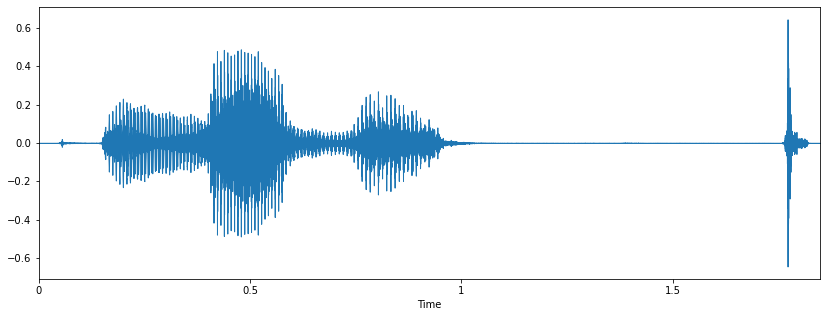

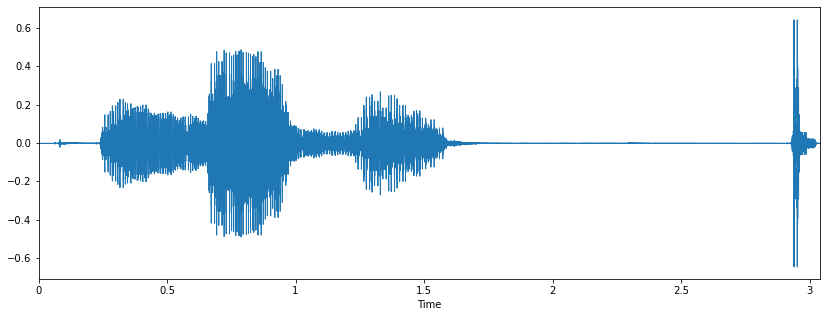

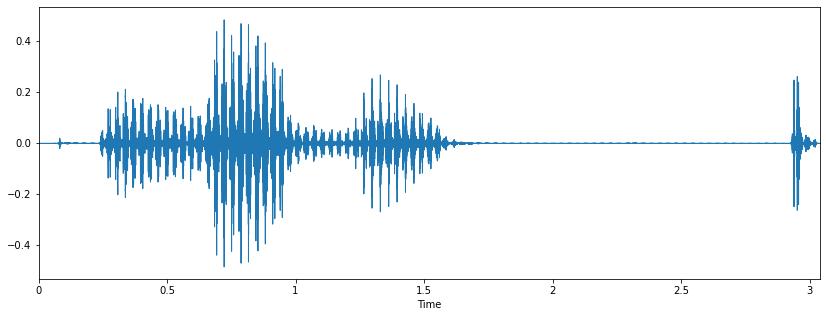

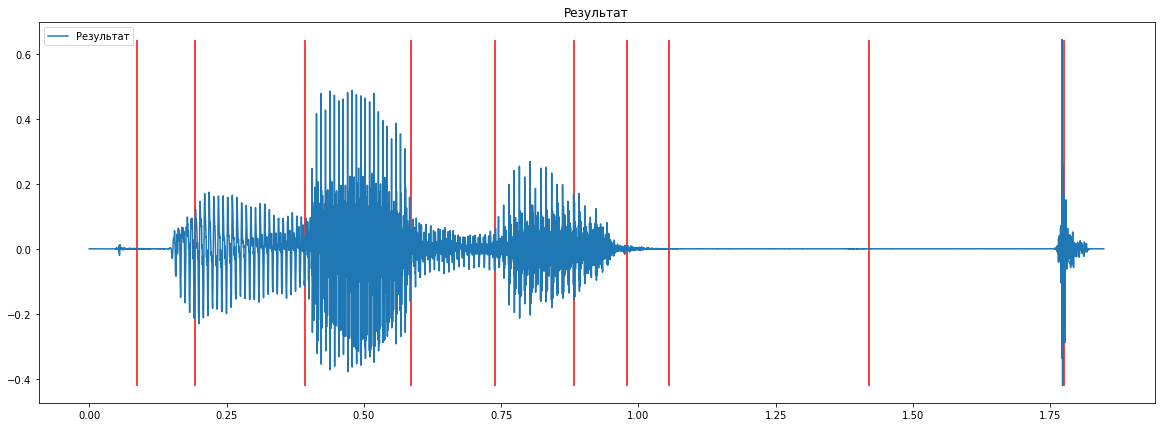

In [14]:
init_par = Initial_params(sr = 16000, offset = 0.0, 
                              duration = 6.0, file_name = './Data/test_data/fast_mama.mp3', 
                              frame_sz = 512, hop_part = 0.6,
                             method = 'db4', level=6,
                             etta = 3.5, g_min = 0.5,
                             min_bound_diff = 0.03)

descrete_sig, frames_coeffs = wavelet_load_data(init_par)

# поиск границ
boundary = frames_find_boundary_classic(frames_coeffs, init_par.etta, init_par.g_min)

# конвертация границ в временные промежутки
t_boundary = convert_boundary_to_t(boundary, init_par.sr, init_par.frame_sz, init_par.hop_part, init_par.offset)

# усредняем промежутки, находящиеся ближе чем на min_bound_diff
t_boundary_filtered = filter_t_boundary(init_par.min_bound_diff, t_boundary)

# интерпретация на графике t_boundary
print(t_boundary_filtered)
print_graphix_with_vertical_lines(init_par.get_t_lst(descrete_sig), descrete_sig, t_boundary_filtered, 'Результат')


In [8]:
def calc_e_j(d_j):
    res = 0
    for d_j_k in d_j:
        res += d_j_k ** 2
    if (res == 0):
        print('error in calc_e_j, res == 0!')
        return 0
    return 10 * log10(res)

def calc_e_i_j(d_list):
    e_j = []
    for d_j in d_list:
        e_j.append(calc_e_j(d_j))
    return e_j
        

def check_boundary_between_frames(e_before_j, e_j, etta):
    res = []
    for e_before, e in zip(e_before_j, e_j):
        # критерий определения границ между фонемами на одном уровне
        if (abs(e - e_before) >= etta):
            # граница есть
            res.append(1)
        else:
            # границы нет
            res.append(0)
    return res
   
    
def frames_find_boundary_classic(frames_coeffs, etta, g_min):
    boundary = []
    # проверка на 0 frames_coeffs
    if (len(frames_coeffs) == 0):
        print('error in frames_find_boundary, len(frames_coeffs) == 0!')
        return []
    e_before_j = calc_e_i_j(frames_coeffs[0])
    for i in range(1, len(frames_coeffs)):
        e_j = calc_e_i_j(frames_coeffs[i])
        # определение границы между фонемами (между фреймами) на всех уровнях
        i_boundary = check_boundary_between_frames(e_before_j, e_j, etta)
        
        
        # критерий определения границ между фонемами на всех уровнях
        if (np.sum(i_boundary) / float(len(i_boundary)) >= g_min):
            boundary.append(i)
        
        e_before_j = e_j
    return boundary

In [9]:
def convert_boundary_to_t(boundary, sr, frame_sz, hop_part, offset):
    res = []
    hop_sz = frame_sz * (1 - hop_part)
    for i in boundary:
        # подсчитывает количество отсчетов
        samples = i * frame_sz * hop_part
        # переводим отсчеты в время
        t = offset + samples / float(sr)
        res.append(t)
    return np.array(res)
    

In [10]:
def filter_t_boundary(min_bound_diff, t_boundary):
    if (len(t_boundary) == 0):
        return []
    before_t = t_boundary[0]
    res = []
    buffer = [before_t]
    for t in t_boundary[1:]:
        if (t - before_t < min_bound_diff):
            buffer.append(t)
        else:
            if (len(buffer) != 0):
                res.append(np.mean(buffer))
            buffer = [t]
        before_t = t
    
    if (len(buffer) != 0):
        res.append(np.mean(buffer))
    return res
        

In [13]:
def print_graphix_with_vertical_lines(x, y, x_lines, name):
    plt.figure(figsize=(20,7))
    plt.plot(x, y)
    plt.vlines(x_lines, y.min(), y.max(), color = 'r')
    plt.legend([name])
    plt.title(name)
    plt.savefig('saved_test_graph.png')
    plt.show()
    

In [38]:
coeffs = wavedec([1,2,3,4,5,6,7,8], 'db1', level=2)
coeffs[2]

array([-0.70710678, -0.70710678, -0.70710678, -0.70710678])

# Загрузка размеченных данных json

In [3]:
def load_json_data(file_name, columns):
    file = open(file_name,'r')
    text = file.read()
    text = json.loads(text)
    df = json_normalize(text, 'phonemes')
    df['start'] = pd.to_numeric(df['start'], downcast='float')
    df['end'] = pd.to_numeric(df['end'], downcast='float')
    df = df.sort_values(columns)
    return df[columns].values

In [241]:
#df['start'].values.shape
df['start'].values[-10:]

array([386.083, 386.196, 386.327, 386.408, 386.502, 386.508, 386.615,
       386.702, 386.777, 386.88 ], dtype=float32)

# Нейросетевой подход
## Попытка в лоб (берем первое попавшееся и предсказываем)

In [328]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [352]:
X = [1,2,3,4,5,6,7]
y = [0,1,2,3,4,5,6]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

print(X_train, Y_train)
print(X_test, Y_test)

[1, 2, 3, 4, 5] [0, 1, 2, 3, 4]
[6, 7] [5, 6]


0

/Users/ilyalevuskin/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/ilyalevuskin/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.9889148191365228


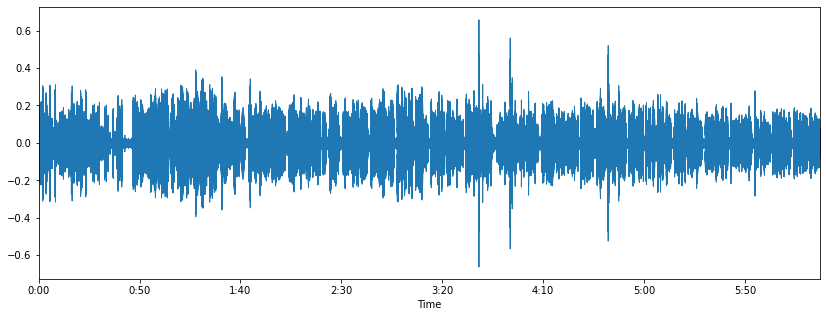

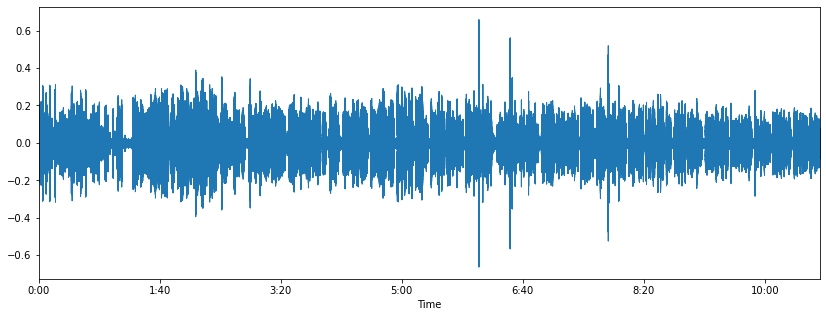

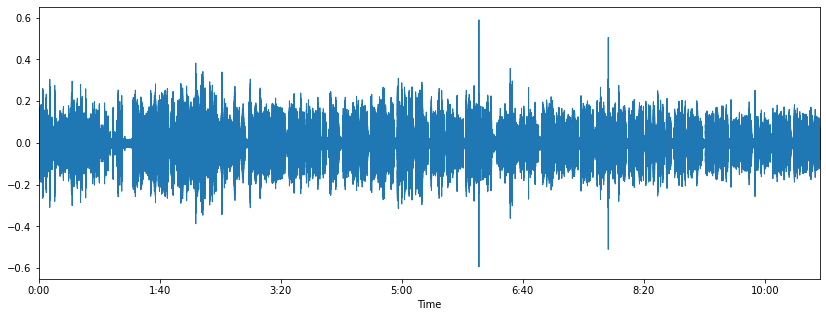

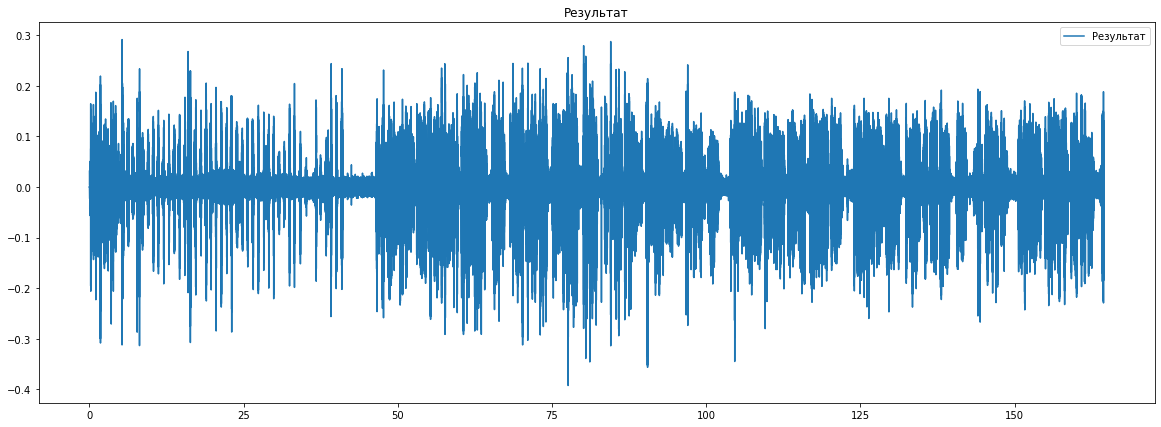

In [374]:

init_par = Initial_params(sr = 16000, offset = 0.0, 
                          duration = 387., file_name = './audio10.mp3', 
                          frame_sz = 512, hop_part = 0.6,
                         method = 'db4', level=6,
                         etta = 3.5, g_min = 0.5,
                         min_bound_diff = 0.03)

test_time = 1.7

test_size = test_time / duration

descrete_sig, frames_coeffs = wavelet_load_data(init_par)

# получаем размеченные данные
t_values = load_json_data('./Audiozapis10.json', 'start')

# формируем данные для обучения
X, y = prepare_data_for_model(frames_coeffs, init_par.frame_sz, init_par.hop_part, 
                              init_par.sr, init_par.offset, t_values)


X_test, X_train, Y_test, Y_train = train_test_split(X, y, test_size=1 - test_size, shuffle=False)

# обучение нейросети искать границы
model = fit_frames_sig(X_train, Y_train) 

# предсказание нейросети
frames_border = model.predict(X_test)

# оценка предсказания
print(metrics.accuracy_score(frames_border, Y_test))

# конвертация границ в временные промежутки
t_boundary = convert_frame_pos_to_time_value(frames_border, init_par.sr, 
                                             init_par.frame_sz, init_par.hop_part, init_par.offset)

# усредняем промежутки, находящиеся ближе чем на min_bound_diff
#t_boundary_filtered = filter_t_boundary(init_par.min_bound_diff, t_boundary)

# интерпретация на графике t_boundary

print_graphix_with_vertical_lines(init_par.get_t_lst(descrete_sig[:int(len(descrete_sig) * test_size)]), 
                                  descrete_sig[:int(len(descrete_sig) * test_size)], t_boundary, 'Результат')



In [370]:
def convert_time_value_to_frame_pos(t_lst, frame_sz, hop_part, sr, offset, frames_length):
    res = []
    for t in t_lst:
        frame_pos = round((t - offset) * sr / float(frame_sz * hop_part))
        res.append(frame_pos)
    frames_count = np.arange(frames_length - 1)
    y = [0 if i not in res else 1 for i in frames_count]
    return y

def convert_frame_pos_to_time_value(frames_border, sr, frame_sz, hop_part, offset):
    # пребразуем массив вида [1,0,0,0,1,0] в [1,0,0,0,5,0]
    boundary = np.array([i + 1 if frames_border[i] == 1 else 0 for i in range(len(frames_border))])
    return convert_boundary_to_t(boundary[boundary > 0], sr, frame_sz, hop_part, offset)
    

In [369]:
lst1 = np.array([1,0,0,0,1,0])
lst2 = np.array([i + 1 if lst1[i] == 1 else 0 for i in range(len(lst1))])
print(lst2)

[1 0 0 0 5 0]


In [346]:

def prepare_data_for_model(frames_coeffs, frame_sz, hop_part, sr, offset, t_values):
    X = [np.concatenate([np.concatenate(frames_coeffs[i - 1], axis=0), np.concatenate(frames_coeffs[i], axis=0)]) 
         for i in range(1, len(frames_coeffs))]
    y = convert_time_value_to_frame_pos(t_values, frame_sz, hop_part, sr, offset, len(frames_coeffs))
    return X, y

def fit_frames_sig(X, y):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X, y)
    return clf

## Обучение нейросети

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

X = [np.concatenate([np.concatenate(frames_coeffs[i - 1], axis=0), np.concatenate(frames_coeffs[i], axis=0)]) 
         for i in range(1, len(frames_coeffs))]
Y_train = convert_time_value_to_frame_pos(df['start'].values, frame_sz, hop_part, sr, offset, len(frames_coeffs))

clf.fit(X_train, Y_train)

In [307]:
14*7

98

In [233]:
lst1 = [1,2,3,4,5,6,7,8,9,10]
res = [(lst1[i - 1], lst1[i]) for i in range(1, len(lst1))]
res

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]

In [231]:
a = [0,1,2,3,4,5,6,7,8]
b = [1,2,3,5]

c = [0 if i not in b else 1 for i in a]
print(c)

[0, 1, 1, 1, 0, 1, 0, 0, 0]
